## Import Required Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tabulate import tabulate


c:\Users\Vasan\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


##  Load and Filter ESG Data


In [2]:
import pandas as pd

def load_and_filter_esg_data(file_path: str, year: str, pillar: str = None) -> pd.DataFrame:
    """
    Loads ESG data from a CSV file and filters it by year and (optionally) by pillar.

    Parameters:
    - file_path (str): Path to the ESG CSV file.
    - year (str or int): Year to filter the data.
    - pillar (str, optional): ESG Pillar to filter (e.g., 'Environmental', 'Social', 'Governance').

    Returns:
    - pd.DataFrame: Filtered ESG DataFrame.
    """
    # Load CSV
    df = pd.read_csv(file_path, sep='|', encoding='utf-8')

    # Show columns to verify structure
    print(" Loaded columns:", df.columns.tolist())

    # Check and apply year filter
    if 'year' not in df.columns:
        raise ValueError("The 'year' column was not found in the dataset.")
    df = df[df['year'] == int(year)]

    # Check and apply pillar filter
    if pillar:
        if 'pillar' not in df.columns:
            raise ValueError("The 'pillar' column was not found in the dataset.")
        df = df[df['pillar'].str.lower() == pillar.lower()]

    # Keep only necessary columns
    filtered_df = df[['company_name', 'metric_name', 'metric_value_scaled']].copy()
    filtered_df = filtered_df[filtered_df['metric_value_scaled'].notnull()]

    print(f" Filtered ESG data for year {year}" + (f" and pillar '{pillar}'" if pillar else "") + f". Rows: {filtered_df.shape[0]}")
    return filtered_df


##  Pivot and Impute ESG Data


In [3]:
def pivot_and_impute_esg_data(filtered_df: pd.DataFrame) -> pd.DataFrame:
    """
    Pivots the ESG data to create a company × metric matrix and imputes missing values
    with column-wise mean.

    Parameters:
    - filtered_df (pd.DataFrame): DataFrame with 'company_name', 'metric_name', and 'metric_value_scaled'.

    Returns:
    - pd.DataFrame: Clean pivoted matrix with no missing values.
    """
    # Pivot data to company × metric matrix
    pivot_df = filtered_df.pivot_table(index='company_name',
                                       columns='metric_name',
                                       values='metric_value_scaled',
                                       aggfunc='mean')

    # Impute missing values using column-wise mean
    pivot_df_clean = pivot_df.fillna(pivot_df.mean())

    # Optional: Show the resulting shape
    print(" Pivoted ESG matrix shape:", pivot_df_clean.shape)

    return pivot_df_clean


In [4]:
##  Standardize Data and Perform PCA


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd

def perform_pca_on_esg_data(pivot_df_clean: pd.DataFrame, n_components: int = 2):
    """
    Standardizes ESG data and applies PCA.

    Parameters:
    - pivot_df_clean (pd.DataFrame): Cleaned company × metric ESG matrix.
    - n_components (int): Number of PCA components (default=2).

    Returns:
    - pca_model: fitted PCA model
    - pca_df: DataFrame with PCA components
    - scaled_data: standardized ESG data
    """
    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(pivot_df_clean)

    # Apply PCA
    pca_model = PCA(n_components=n_components)
    pca_components = pca_model.fit_transform(scaled_data)

    # Store PCA components in DataFrame
    pca_df = pd.DataFrame(pca_components,
                          columns=[f'PC{i+1}' for i in range(n_components)],
                          index=pivot_df_clean.index)
    pca_df.reset_index(inplace=True)

    print(" PCA applied. PCA DataFrame shape:", pca_df.shape)
    return pca_model, pca_df, scaled_data


In [6]:
##  Analyze PCA Loadings to Identify Top ESG Metrics


In [7]:
import pandas as pd
from sklearn.decomposition import PCA

def analyze_pca_loadings(pca_model: PCA, pivot_df_clean: pd.DataFrame, top_n: int = 10) -> tuple:
    """
    Analyzes PCA loadings to identify the top contributing ESG metrics to PC1 and PC2.

    Parameters:
    - pca_model (PCA): Fitted PCA object.
    - pivot_df_clean (pd.DataFrame): DataFrame used to fit PCA (for column names).
    - top_n (int): Number of top metrics to return for each component.

    Returns:
    - loadings_df (pd.DataFrame): Loadings DataFrame with absolute values.
    - top_pc1 (pd.DataFrame): Top N metrics contributing to PC1.
    - top_pc2 (pd.DataFrame): Top N metrics contributing to PC2.
    """
    loadings = pca_model.components_.T

    loadings_df = pd.DataFrame(loadings,
                               index=pivot_df_clean.columns,
                               columns=[f'PC{i+1}' for i in range(pca_model.n_components_)])

    # Add absolute values for sorting
    for pc in loadings_df.columns:
        loadings_df[f'{pc}_abs'] = loadings_df[pc].abs()

    # Extract top contributors
    top_pc1 = loadings_df.sort_values(by='PC1_abs', ascending=False)[['PC1']].head(top_n)
    top_pc2 = loadings_df.sort_values(by='PC2_abs', ascending=False)[['PC2']].head(top_n)

   # Step 5: Convert to DataFrame with reset index for easier access
    top_pc1_array = top_pc1.reset_index()
    top_pc1_array.columns = ['Metric Name', 'Loading Value']

    top_pc2_array = top_pc2.reset_index()
    top_pc2_array.columns = ['Metric Name', 'Loading Value']

    # Step 6: Build dictionary of top metric names
    top_metrics_dict = {
        "PC1": top_pc1_array['Metric Name'].tolist(),
        "PC2": top_pc2_array['Metric Name'].tolist()
    }

    # Step 7: Preview the top contributors
    print("\nTop PC1 Metrics:")
    print(tabulate(top_pc1_array, headers='keys', tablefmt='psql', showindex=False))

    print("\nTop PC2 Metrics:")
    print(tabulate(top_pc2_array, headers='keys', tablefmt='psql', showindex=False))

    # Step 8: Return everything
    return loadings_df, top_pc1_array, top_pc2_array, top_metrics_dict


##  Plot Heatmap of Top ESG Metric Contributions


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_top_metric_heatmap(top_pc1: pd.DataFrame,
                            top_pc2: pd.DataFrame,
                            loadings_df: pd.DataFrame,
                            title: str = " Top ESG Metric Contributions to PC1 and PC2") -> None:
    """
    Plots a heatmap of PCA loadings for top contributing metrics to PC1 and PC2.

    Parameters:
    - top_pc1 (pd.DataFrame): DataFrame of top PC1 metrics with loading values.
    - top_pc2 (pd.DataFrame): DataFrame of top PC2 metrics with loading values.
    - loadings_df (pd.DataFrame): Full PCA loadings DataFrame.
    - title (str): Plot title.
    """

    # Step 1: Combine top metrics from PC1 and PC2
    top_metrics = pd.concat([top_pc1, top_pc2])
    top_metrics = top_metrics.drop_duplicates(subset='Metric Name')

    # Step 2: Slice relevant loadings
    heatmap_data = loadings_df.loc[top_metrics['Metric Name'], ['PC1', 'PC2']]

    # Step 3: Plot the heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        cmap='coolwarm',
        center=0,
        cbar_kws={'label': 'PCA Loading'}
    )
    plt.title(title, fontsize=14)
    plt.xlabel("Principal Components", fontsize=12)
    plt.ylabel("ESG Metrics", fontsize=12)
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


##  Plot PCA Scatter Plot of Companies


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_pca_scatter(pca_df: pd.DataFrame,
                     x_col: str = 'PC1',
                     y_col: str = 'PC2',
                     title: str = " PCA Scatter Plot of Companies Based on ESG Profiles",
                     color: str = 'steelblue') -> None:
    """
    Plots a scatter plot of companies based on their PCA component scores.

    Parameters:
    - pca_df (pd.DataFrame): DataFrame containing PCA results with PC1, PC2 and index (company).
    - x_col (str): Column name for X-axis (default: 'PC1').
    - y_col (str): Column name for Y-axis (default: 'PC2').
    - title (str): Plot title.
    - color (str): Dot color.
    """

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pca_df, x=x_col, y=y_col, color=color, s=70)

    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


##  Plot Scree Plot for Explained Variance


In [10]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA

def plot_scree_plot(scaled_data: np.ndarray,
                    title: str = ' Scree Plot: Explained Variance by PCA Components') -> None:
    """
    Generates a scree plot showing the explained variance by each principal component.

    Parameters:
    - scaled_data (np.ndarray): Standardized ESG feature matrix.
    - title (str): Custom title for the plot.
    """

    # Fit PCA with all components
    pca_full = PCA()
    pca_full.fit(scaled_data)

    explained_variance = pca_full.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)

    # Create the scree plot
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance,
            alpha=0.5, align='center', label='Individual Explained Variance')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance,
             where='mid', label='Cumulative Explained Variance', color='red')

    plt.xlabel('Principal Component Index')
    plt.ylabel('Explained Variance Ratio')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


##  Plot PCA Biplot Highlighting Top ESG Metric Drivers


In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_pca_biplot_top2_features(pca_df: pd.DataFrame,
                                  loadings_df: pd.DataFrame,
                                  scale: float = 8,
                                  arrow_colors: list = ['darkred', 'darkgreen'],
                                  title: str = " Clean PCA Biplot: Top ESG Metric Drivers") -> None:
    """
    Plots a PCA biplot with the top contributing features for PC1 and PC2 as arrows.

    Parameters:
    - pca_df (pd.DataFrame): DataFrame containing PC1 and PC2 columns for each company.
    - loadings_df (pd.DataFrame): PCA loadings DataFrame with columns ['PC1', 'PC2', 'PC1_abs', 'PC2_abs'].
    - scale (float): Scaling factor for arrow length.
    - arrow_colors (list): List of two colors for the PC1 and PC2 arrows.
    - title (str): Plot title.
    """
    # Identify top features
    top_pc1_feature = loadings_df['PC1_abs'].idxmax()
    top_pc2_feature = loadings_df['PC2_abs'].idxmax()
    selected_features = [top_pc1_feature, top_pc2_feature]

    # Set up plot
    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Scatter plot of companies
    ax.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.5, color='skyblue', s=50)

    # Draw arrows and labels
    for i, feature in enumerate(selected_features):
        x = loadings_df.loc[feature, 'PC1'] * scale
        y = loadings_df.loc[feature, 'PC2'] * scale

        ax.arrow(0, 0, x, y, color=arrow_colors[i], linewidth=2.5,
                 head_width=0.5, head_length=0.7, length_includes_head=True, alpha=0.8)

        ax.text(x * 1.15, y * 1.15, feature,
                fontsize=14, color=arrow_colors[i], fontweight='bold',
                ha='center', va='center',
                bbox=dict(boxstyle='round,pad=0.3', fc='white', alpha=0.9))

    # Final plot formatting
    ax.set_xlabel("Principal Component 1", fontsize=12)
    ax.set_ylabel("Principal Component 2", fontsize=12)
    ax.set_title(title, fontsize=15)
    ax.axhline(0, color='grey', linewidth=0.5, linestyle='--')
    ax.axvline(0, color='grey', linewidth=0.5, linestyle='--')
    ax.grid(True)
    plt.tight_layout()
    plt.show()


##  Run Full PCA Analysis Pipeline


In [12]:
def run_pca_pipeline(file_path: str, year: str, pillar: str = None):
    """
    Orchestrates the traditional PCA analysis pipeline on ESG data fully.

    Parameters:
    - file_path: str: Path to the ESG CSV data file.
    - year: str: Year to filter data on.
    - pillar: str (optional): ESG Pillar to filter by (e.g., 'Environmental', 'Social', 'Governance').
    """
   # Step 1: Load and filter data
    filtered_df = load_and_filter_esg_data(file_path, year)

    # Step 2: Create pivot table
    pivot_df_clean = pivot_and_impute_esg_data(filtered_df)

    # Step 3: Apply PCA
    pca_model, pca_df, scaled_data = perform_pca_on_esg_data(pivot_df_clean)

    # Step 4: Extract loadings and top metrics
    loadings_df, top_pc1, top_pc2, top_metrics_dict = analyze_pca_loadings(pca_model, pivot_df_clean)

    # Step 5: Plot heatmap of contributions
    plot_top_metric_heatmap(top_pc1, top_pc2, loadings_df)

    # Step 6: Scatter plot of companies in PCA space
    plot_pca_scatter(pca_df)

    # Step 7: Clean biplot with 2 dominant metrics
    plot_pca_biplot_top2_features(pca_df, loadings_df)

    # Step 8: Scree plot for explained variance
    plot_scree_plot(scaled_data)

    print(" PCA analysis pipeline completed successfully.")


 Loaded columns: ['company_name', 'perm_id', 'data_type', 'disclosure', 'metric_description', 'metric_name', 'metric_unit', 'metric_value', 'nb_points_of_observations', 'pillar', 'Industry', 'year', 'metric_value_scaled', 'metric_value_log']
 Filtered ESG data for year 2020. Rows: 11426
 Pivoted ESG matrix shape: (785, 82)
 PCA applied. PCA DataFrame shape: (785, 3)

Top PC1 Metrics:
+-------------------------------+-----------------+
| Metric Name                   |   Loading Value |
|-------------------------------+-----------------|
| POLICY_EMISSIONS              |        0.229432 |
| POLICY_FORCED_LABOR           |        0.228847 |
| POLICY_FREEDOMOF_ASSOCIATION  |        0.218517 |
| POLICY_WATER_EFFICIENCY       |        0.211827 |
| POLICY_HUMAN_RIGHTS           |        0.204687 |
| EMPLOYEE_HEALTH_SAFETY_POLICY |        0.198083 |
| POLICY_DATA_PRIVACY           |        0.196999 |
| HUMAN_RIGHTS_CONTRACTOR       |        0.196674 |
| CSR_REPORTING_EXTERNAL_AUDIT  |        

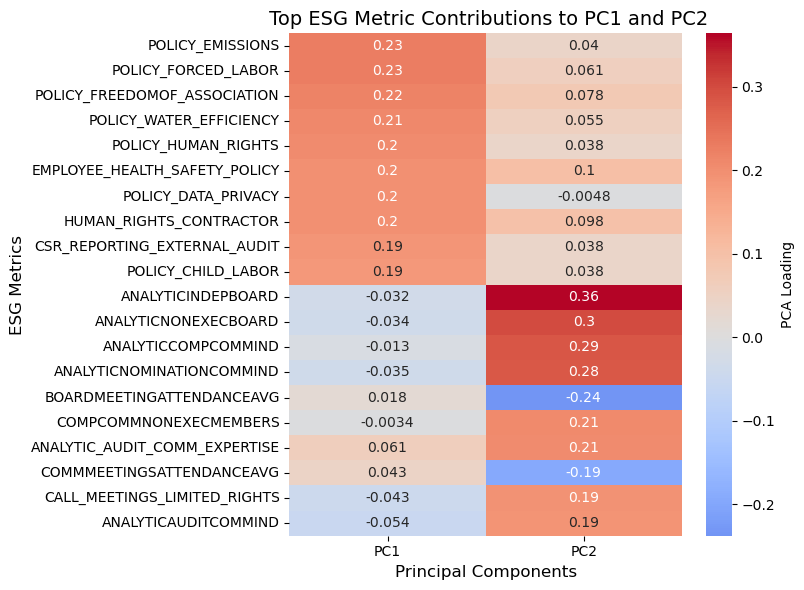

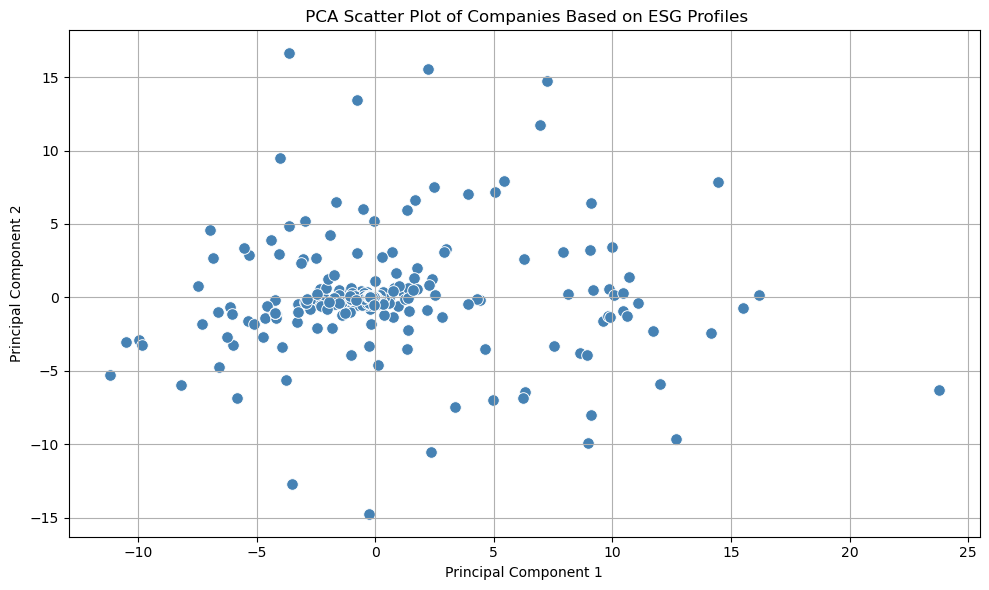

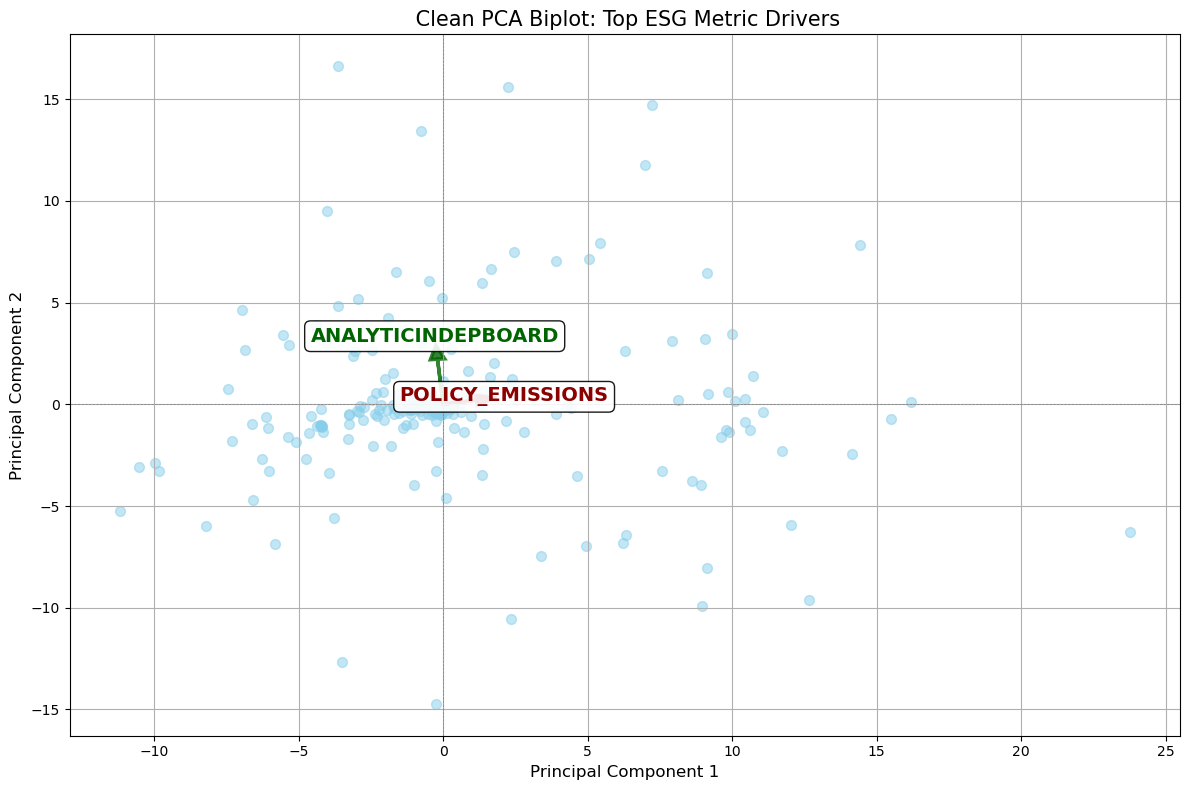

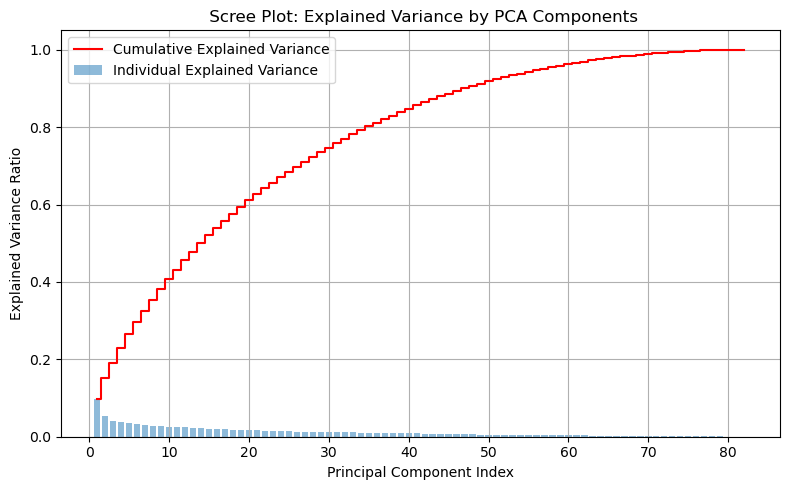

 PCA analysis pipeline completed successfully.


In [13]:
run_pca_pipeline(r"C:\Users\Vasan\OneDrive\Desktop\Final_project\capstone-project-2025-t1-25t1-9900-t12a-chocolate\Normalized_Data\semiconductors_esg_consolidated.csv", year="2020", pillar="E_risk")
